# Automated Trading

In [1]:
import math
import time
import numpy as np
import pandas as pd
import datetime as dt
import cufflinks as cf
from pylab import mpl, plt

In [2]:
np.random.seed(1000)
plt.style.use('seaborn-v0_8')
mpl.rcParams['font.family'] = 'serif'
%matplotlib inline

## Capital Management

### Kelly Criterion in a Binomial Setting

In [3]:
p = 0.55
f = p - (1 - p)  
f

0.10000000000000009

In [4]:
I = 50  
n = 100  

In [5]:
def run_simulation(f):
    c = np.zeros((n, I))  
    c[0] = 100  
    for i in range(I):  
        for t in range(1, n):  
            o = np.random.binomial(1, p)  
            if o > 0:  
                c[t, i] = (1 + f) * c[t - 1, i]  
            else:  
                c[t, i] = (1 - f) * c[t - 1, i]  
    return c

In [6]:
c_1 = run_simulation(f)  

In [7]:
c_1.round(2)

array([[100.  , 100.  , 100.  , ..., 100.  , 100.  , 100.  ],
       [ 90.  , 110.  ,  90.  , ..., 110.  ,  90.  , 110.  ],
       [ 99.  , 121.  ,  99.  , ..., 121.  ,  81.  , 121.  ],
       ...,
       [226.35, 338.13, 413.27, ..., 123.97, 123.97, 123.97],
       [248.99, 371.94, 454.6 , ..., 136.37, 136.37, 136.37],
       [273.89, 409.14, 409.14, ..., 122.73, 150.01, 122.73]])

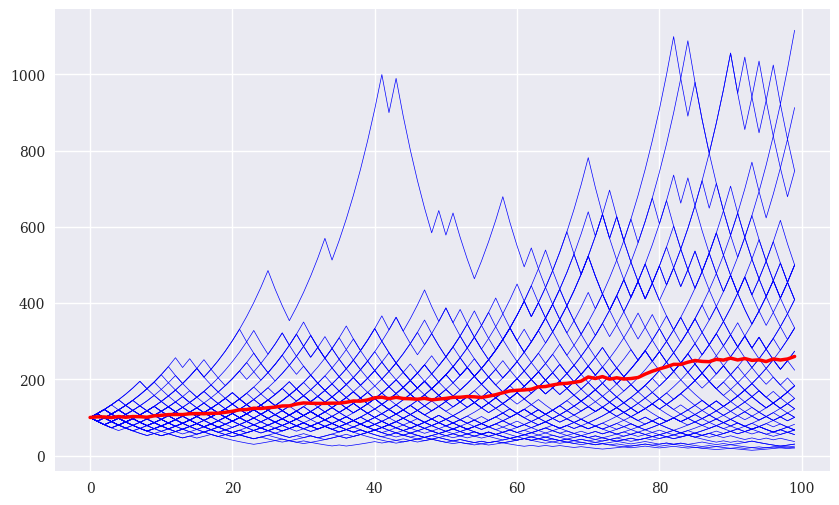

In [8]:
plt.figure(figsize=(10, 6))
plt.plot(c_1, 'b', lw=0.5)  
plt.plot(c_1.mean(axis=1), 'r', lw=2.5);  
# plt.savefig('../../images/ch16/auto_plot_01.png');

In [9]:
c_2 = run_simulation(0.05)  

In [10]:
c_3 = run_simulation(0.25)  

In [11]:
c_4 = run_simulation(0.5)  

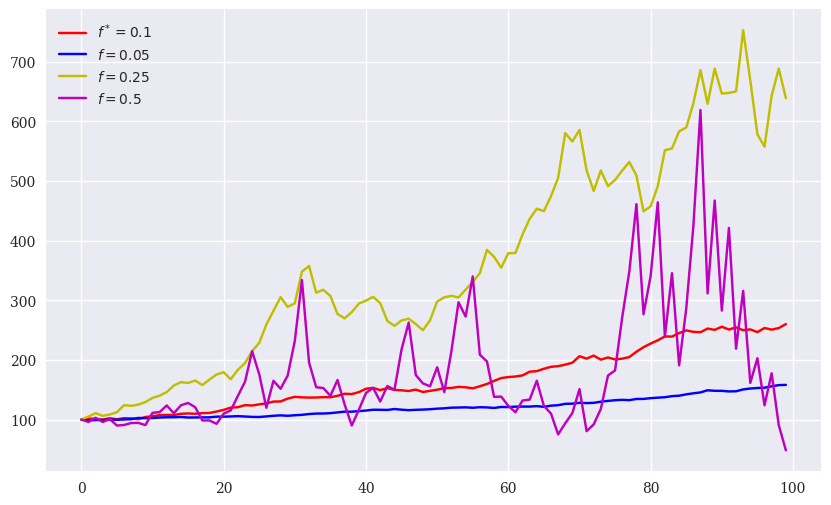

In [12]:
plt.figure(figsize=(10, 6))
plt.plot(c_1.mean(axis=1), 'r', label='$f^*=0.1$')
plt.plot(c_2.mean(axis=1), 'b', label='$f=0.05$')
plt.plot(c_3.mean(axis=1), 'y', label='$f=0.25$')
plt.plot(c_4.mean(axis=1), 'm', label='$f=0.5$')
plt.legend(loc=0);
# plt.savefig('../../images/ch16/auto_plot_02.png');

### Kelly Criterion for Stocks and Indices

In [13]:
raw = pd.read_csv('http://hilpisch.com/tr_eikon_eod_data.csv',
                  index_col=0, parse_dates=True)

In [14]:
symbol = '.SPX'

In [15]:
data = pd.DataFrame(raw[symbol])

In [16]:
data['returns'] = np.log(data / data.shift(1))

In [17]:
data.dropna(inplace=True)

In [18]:
data.tail()

,.SPX,returns
Date,,
2018-06-25,2717.07,-0.013820
2018-06-26,2723.06,0.002202
2018-06-27,2699.63,-0.008642
2018-06-28,2716.31,0.006160
2018-06-29,2718.37,0.000758


In [19]:
mu = data.returns.mean() * 252  

In [20]:
mu  

np.float64(0.09898579893004976)

In [21]:
sigma = data.returns.std() * 252 ** 0.5  

In [22]:
sigma  

np.float64(0.1488567510081967)

In [23]:
r = 0.0  

In [24]:
f = (mu - r) / sigma ** 2 

In [25]:
f  

np.float64(4.4672043679706865)

In [26]:
equs = []

In [27]:
def kelly_strategy(f):
    global equs
    equ = 'equity_{:.2f}'.format(f)
    equs.append(equ)
    cap = 'capital_{:.2f}'.format(f)
    data[equ] = 1  
    data[cap] = data[equ] * f  
    for i, t in enumerate(data.index[1:]):
        t_1 = data.index[i]  
        data.loc[t, cap] = data[cap].loc[t_1] * \
                            math.exp(data['returns'].loc[t])  
        data.loc[t, equ] = data[cap].loc[t] - \
                            data[cap].loc[t_1] + \
                            data[equ].loc[t_1]  
        data.loc[t, cap] = data[equ].loc[t] * f  

In [28]:
kelly_strategy(f * 0.5)  

C:\Users\하민수\AppData\Local\Temp\ipykernel_24984\1162133538.py:12: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.0012184856879518' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.



In [29]:
kelly_strategy(f * 0.66)  

C:\Users\하민수\AppData\Local\Temp\ipykernel_24984\1162133538.py:12: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.0016084011080966' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.



In [30]:
kelly_strategy(f)  

C:\Users\하민수\AppData\Local\Temp\ipykernel_24984\1162133538.py:12: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.0024369713759036' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.



In [31]:
print(data[equs].tail())

            equity_2.23  equity_2.95  equity_4.47
Date                                             
2018-06-25     4.707070     6.367340     8.794342
2018-06-26     4.730248     6.408727     8.880952
2018-06-27     4.639340     6.246147     8.539593
2018-06-28     4.703365     6.359932     8.775296
2018-06-29     4.711332     6.374152     8.805026


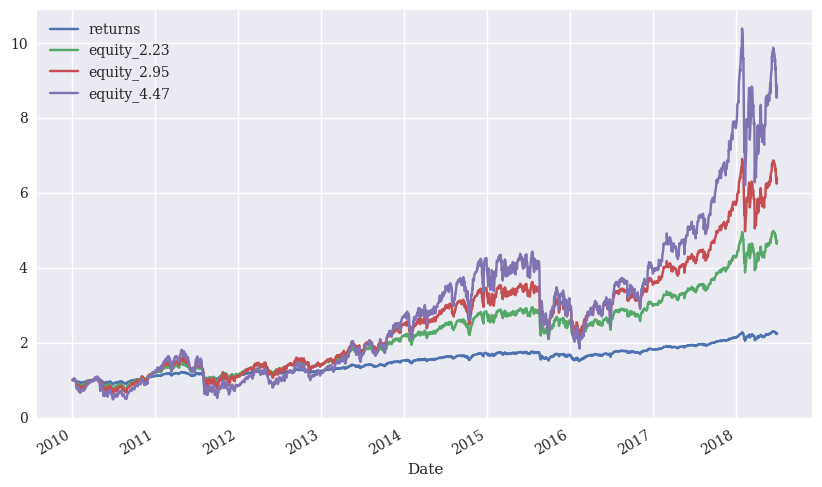

In [32]:
ax = data['returns'].cumsum().apply(np.exp).plot(legend=True, figsize=(10, 6))
data[equs].plot(ax=ax, legend=True);
# plt.savefig('../../images/ch16/auto_plot_03.png');

## ML-Based Trading Strategy

### Vectorized Backtesting

In [33]:
import fxcmpy

In [34]:
fxcmpy.__version__

'1.1.16'

In [39]:
%time api = fxcmpy.fxcmpy(access_token='D251046090', log_level='error')  

|ERROR|2024-11-13 17:40:10,993|Socket returns an error: HTTPSConnectionPool(host='api-demo.fxcm.com', port=443): Max retries exceeded with url: /socket.io/?access_token=D251046090&agent=pythonquants&EIO=3&transport=polling&t=1731487210920-0 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x00000214F6354FD0>: Failed to resolve 'api-demo.fxcm.com' ([Errno 11001] getaddrinfo failed)")).


ServerError: Can not connect to FXCM Server.

In [38]:
data = api.get_candles('EUR/USD', period='m5',
                        start='2018-06-01 00:00:00',
                        stop='2018-06-30 00:00:00')  

NameError: name 'api' is not defined

In [ ]:
data.iloc[-5:, 4:]

,askopen,askclose,askhigh,asklow,tickqty
date,,,,,
2018-06-29 20:35:00,1.16862,1.16882,1.16896,1.16839,601
2018-06-29 20:40:00,1.16882,1.16853,1.16898,1.16852,387
2018-06-29 20:45:00,1.16853,1.16826,1.16862,1.16822,592
2018-06-29 20:50:00,1.16826,1.16836,1.16846,1.16819,842
2018-06-29 20:55:00,1.16836,1.16861,1.16876,1.16834,540


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6083 entries, 2018-06-01 00:00:00 to 2018-06-29 20:55:00
Data columns (total 9 columns):
bidopen     6083 non-null float64
bidclose    6083 non-null float64
bidhigh     6083 non-null float64
bidlow      6083 non-null float64
askopen     6083 non-null float64
askclose    6083 non-null float64
askhigh     6083 non-null float64
asklow      6083 non-null float64
tickqty     6083 non-null int64
dtypes: float64(8), int64(1)
memory usage: 475.2 KB


In [ ]:
spread = (data['askclose'] - data['bidclose']).mean()  
spread  

2.6338977478217845e-05

In [ ]:
data['midclose'] = (data['askclose'] + data['bidclose']) / 2  

In [ ]:
ptc = spread / data['midclose'].mean()  
ptc  

2.255685318140426e-05

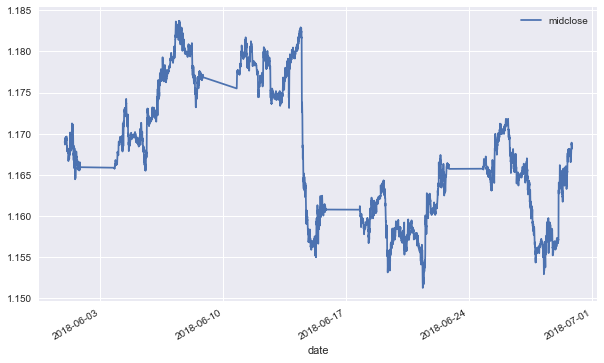

In [ ]:
data['midclose'].plot(figsize=(10, 6), legend=True);
# plt.savefig('../../images/ch16/auto_plot_04.png');

In [ ]:
data['returns'] = np.log(data['midclose'] / data['midclose'].shift(1))

In [ ]:
data.dropna(inplace=True)

In [ ]:
lags = 5

In [ ]:
cols = []
for lag in range(1, lags + 1):
    col = 'lag_{}'.format(lag)
    data[col] = data['returns'].shift(lag)  
    cols.append(col)

In [ ]:
data.dropna(inplace=True)

In [ ]:
data[cols] = np.where(data[cols] > 0, 1, 0)  

In [ ]:
data['direction'] = np.where(data['returns'] > 0, 1, -1)  

In [ ]:
data[cols + ['direction']].head()

,lag_1,lag_2,lag_3,lag_4,lag_5,direction
date,,,,,,
2018-06-01 00:30:00,1,0,1,0,1,1
2018-06-01 00:35:00,1,1,0,1,0,1
2018-06-01 00:40:00,1,1,1,0,1,1
2018-06-01 00:45:00,1,1,1,1,0,1
2018-06-01 00:50:00,1,1,1,1,1,-1


In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

In [ ]:
model = SVC(C=1, kernel='linear')

In [ ]:
split = int(len(data) * 0.80)

In [ ]:
train = data.iloc[:split].copy()

In [ ]:
model.fit(train[cols], train['direction'])

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [ ]:
accuracy_score(train['direction'], model.predict(train[cols]))  

0.5198518823287389

In [ ]:
test = data.iloc[split:].copy()

In [ ]:
test['position'] = model.predict(test[cols])

In [ ]:
accuracy_score(test['direction'], test['position'])  

0.5419407894736842

In [ ]:
test['strategy'] = test['position'] * test['returns']  

In [ ]:
sum(test['position'].diff() != 0)  

660

In [ ]:
test['strategy_tc'] = np.where(test['position'].diff() != 0,
                               test['strategy'] - ptc,  
                               test['strategy'])

In [ ]:
test[['returns', 'strategy', 'strategy_tc']].sum(
        ).apply(np.exp)

returns        0.999324
strategy       1.026141
strategy_tc    1.010977
dtype: float64

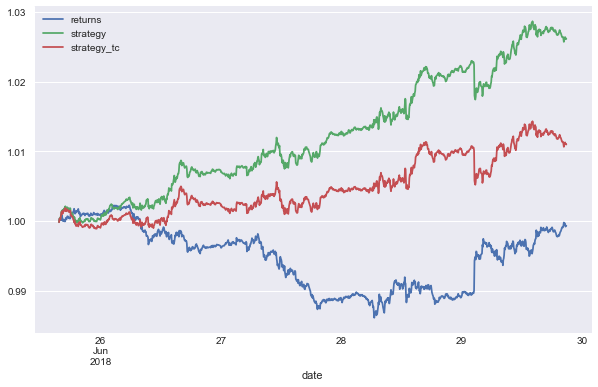

In [ ]:
test[['returns', 'strategy', 'strategy_tc']].cumsum(
        ).apply(np.exp).plot(figsize=(10, 6));
# plt.savefig('../../images/ch16/auto_plot_05.png');

In [ ]:
mean = test[['returns', 'strategy_tc']].mean() * len(data) * 12  
mean

returns       -0.040535
strategy_tc    0.654711
dtype: float64

In [ ]:
var = test[['returns', 'strategy_tc']].var() * len(data) * 12  
var

returns        0.007861
strategy_tc    0.007837
dtype: float64

In [ ]:
vol = var ** 0.5  
vol

returns        0.088663
strategy_tc    0.088524
dtype: float64

In [ ]:
mean / var  

returns        -5.156448
strategy_tc    83.545792
dtype: float64

In [ ]:
mean / var * 0.5  

returns        -2.578224
strategy_tc    41.772896
dtype: float64

In [ ]:
to_plot = ['returns', 'strategy_tc']  

In [ ]:
for lev in [10, 20, 30, 40, 50]:  
    label = 'lstrategy_tc_%d' % lev  
    test[label] = test['strategy_tc'] * lev  
    to_plot.append(label)  

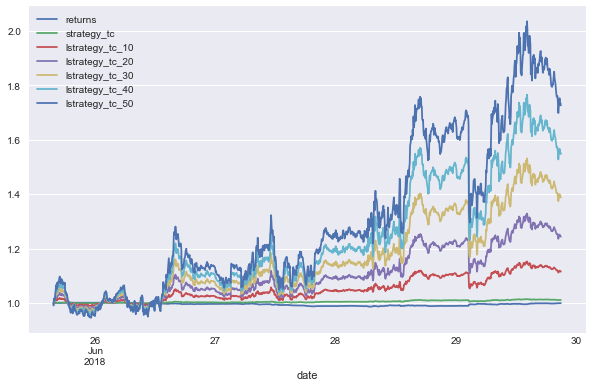

In [ ]:
test[to_plot].cumsum().apply(np.exp).plot(figsize=(10, 6));
# plt.savefig('../../images/ch16/auto_plot_06.png');

### Risk Analysis

In [ ]:
equity = 3333  

In [ ]:
risk = pd.DataFrame(test['lstrategy_tc_30'])  

In [ ]:
risk['equity'] = risk['lstrategy_tc_30'].cumsum().apply(np.exp) * equity  

In [ ]:
risk['cummax'] = risk['equity'].cummax()  

In [ ]:
risk['drawdown'] = risk['cummax'] - risk['equity']  

In [ ]:
risk['drawdown'].max()  

781.7073602069818

In [ ]:
t_max = risk['drawdown'].idxmax()  
t_max  

Timestamp('2018-06-29 02:45:00')

In [ ]:
temp = risk['drawdown'][risk['drawdown'] == 0]  

In [ ]:
periods = (temp.index[1:].to_pydatetime() -
           temp.index[:-1].to_pydatetime())  

In [ ]:
periods[20:30]  

array([datetime.timedelta(seconds=68700),
       datetime.timedelta(seconds=72000),
       datetime.timedelta(seconds=1800), datetime.timedelta(seconds=300),
       datetime.timedelta(seconds=600), datetime.timedelta(seconds=300),
       datetime.timedelta(seconds=17400),
       datetime.timedelta(seconds=4500), datetime.timedelta(seconds=1500),
       datetime.timedelta(seconds=900)], dtype=object)

In [ ]:
t_per = periods.max()  

In [ ]:
t_per  

datetime.timedelta(seconds=76500)

In [ ]:
t_per.seconds / 60 / 60  

21.25

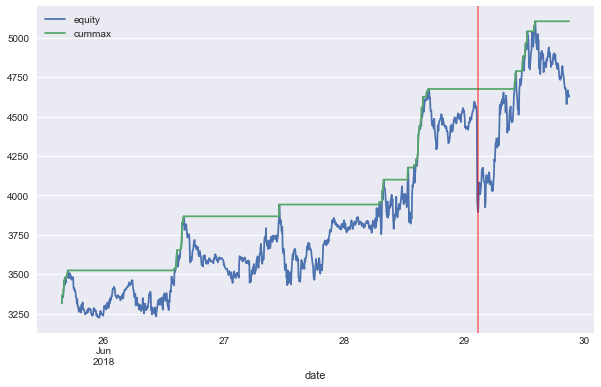

In [ ]:
risk[['equity', 'cummax']].plot(figsize=(10, 6))
plt.axvline(t_max, c='r', alpha=0.5);
# plt.savefig('../../images/ch16/auto_plot_07.png');

In [ ]:
import scipy.stats as scs

In [ ]:
percs = [0.01, 0.1, 1., 2.5, 5.0, 10.0]  

In [ ]:
risk['returns'] = np.log(risk['equity'] /
                         risk['equity'].shift(1))

In [ ]:
VaR = scs.scoreatpercentile(equity * risk['returns'], percs)  

In [ ]:
def print_var():
    print('%16s %16s' % ('Confidence Level', 'Value-at-Risk'))
    print(33 * '-')
    for pair in zip(percs, VaR):
        print('%16.2f %16.3f' % (100 - pair[0], -pair[1]))   

In [ ]:
print_var()  

Confidence Level    Value-at-Risk
---------------------------------
           99.99          400.854
           99.90          175.932
           99.00           88.139
           97.50           60.485
           95.00           45.010
           90.00           32.056


In [ ]:
hourly = risk.resample('1H', label='right').last()  

In [ ]:
hourly['returns'] = np.log(hourly['equity'] /
                         hourly['equity'].shift(1))

In [ ]:
VaR = scs.scoreatpercentile(equity * hourly['returns'], percs)  

In [ ]:
print_var()

Confidence Level    Value-at-Risk
---------------------------------
           99.99          389.524
           99.90          372.657
           99.00          205.662
           97.50          186.999
           95.00          164.869
           90.00          101.835


### Persisting the Model Object

In [ ]:
import pickle

In [ ]:
pickle.dump(model, open('algorithm.pkl', 'wb'))

## Online Algorithm

In [ ]:
algorithm = pickle.load(open('algorithm.pkl', 'rb'))

In [ ]:
algorithm

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [ ]:
sel = ['tradeId', 'amountK', 'currency',
       'grossPL', 'isBuy']  

In [ ]:
def print_positions(pos):
    print('\n\n' + 50 * '=')
    print('Going {}.\n'.format(pos))
    time.sleep(1.5)  
    print(api.get_open_positions()[sel])  
    print(50 * '=' + '\n\n')

In [ ]:
symbol = 'EUR/USD'  
bar = '15s'  
amount = 100  
position = 0   
min_bars = lags + 1  
df = pd.DataFrame()  

In [ ]:
def automated_strategy(data, dataframe):
    global min_bars, position, df
    ldf = len(dataframe)        
    df = dataframe.resample(bar, label='right').last().ffill()  
    if ldf % 20 == 0:
        print('%3d' % len(dataframe), end=',')
    
    if len(df) > min_bars:
        min_bars = len(df)
        df['Mid'] = df[['Bid', 'Ask']].mean(axis=1)
        df['Returns'] = np.log(df['Mid'] / df['Mid'].shift(1))
        df['Direction'] = np.where(df['Returns'] > 0, 1, -1)
        features = df['Direction'].iloc[-(lags + 1):-1]  
        features = features.values.reshape(1, -1)  
        signal = algorithm.predict(features)[0]  

        if position in [0, -1] and signal == 1:  
            api.create_market_buy_order(
                symbol, amount - position * amount)
            position = 1
            print_positions('LONG')
            
        elif position in [0, 1] and signal == -1:  
            api.create_market_sell_order(
                symbol, amount + position * amount)
            position = -1
            print_positions('SHORT')
        
    if len(dataframe) > 350:  
        api.unsubscribe_market_data('EUR/USD')
        api.close_all()

In [ ]:
# api.subscribe_market_data(symbol, (automated_strategy,))

In [ ]:
# api.unsubscribe_market_data(symbol) 

In [ ]:
# api.close_all()

## Logging and Monitoring

In [ ]:
!cat automated_strategy.py

#
# Automated ML-Based Trading Strategy for FXCM
# Online Algorithm, Logging, Monitoring
#
# Python for Finance, 2nd ed.
# (c) Dr. Yves J. Hilpisch
#
import zmq
import time
import pickle
import fxcmpy
import numpy as np
import pandas as pd
import datetime as dt

sel = ['tradeId', 'amountK', 'currency',
       'grossPL', 'isBuy']

log_file = 'automated_strategy.log'

# loads the persisted algorithm object
algorithm = pickle.load(open('algorithm.pkl', 'rb'))

# sets up the socket communication via ZeroMQ (here: "publisher")
context = zmq.Context()
socket = context.socket(zmq.PUB)

# this binds the socket communication to all IP addresses of the machine
socket.bind('tcp://0.0.0.0:5555')


def logger_monitor(message, time=True, sep=True):
    ''' Custom logger and monitor function.
    '''
    with open(log_file, 'a') as f:
        t = str(dt.datetime.now())
        msg = ''
        if time:
            msg += '\n' + t + '\n'
        if sep:
            msg += 66 * '=' + '\n'
        msg +

In [ ]:
!cat strategy_monitoring.py

#
# Automated ML-Based Trading Strategy for FXCM
# Strategy Monitoring via Socket Communication
#
# Python for Finance, 2nd ed.
# (c) Dr. Yves J. Hilpisch
#
import zmq

# sets up the socket communication via ZeroMQ (here: "subscriber")
context = zmq.Context()
socket = context.socket(zmq.SUB)

# adjust the IP address to reflect the remote location if necessary
socket.connect('tcp://206.189.51.42:5555')

# configures the socket to retrieve every message
socket.setsockopt_string(zmq.SUBSCRIBE, '')

while True:
    msg = socket.recv_string()
    print(msg)
